In [55]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-02-27


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import os
import matplotlib
import math
import seaborn as sns

import lib.minibulk_funcs as mb
import lib.figs_funcs as figfunc
import lib.matx_funcs as matxfunc
import lib.fun_plotting as fun_plotting

import lib.NetAnalysis as na

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [58]:
import os
current_path = os.getcwd()
current_path

'/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/Code/Work/1_NetworkInference'

In [59]:
path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/Code/Work/" # for Mac

In [60]:
imp_genes = np.loadtxt(path+"general_info/imp_genes.csv", dtype="str")
imp_genes

array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Tcf7l1',
       'Nanog', 'Sall4', 'Pou5f1', 'Sox2', 'Dnmt3a', 'Dnmt3b', 'Utf1',
       'Otx2', 'Etv5', 'Etv4', 'Nr0b1', 'Zic3', 'Lef1', 'Tcf15', 'Gbx2',
       'Pou3f1', 'Rbpj'], dtype='<U7')

In [61]:
data_type = "raw" # Or  "PsiNorm"
important_genes = True

if important_genes == True:
    text = "imp_genes_"+data_type
else:
    text = data_type
        
print(text)

imp_genes_raw


In [62]:
# GENE CLASSIFICATION
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

genes_order = np.concatenate((naive, formative, committed))
nc_genes = np.setdiff1d(imp_genes, genes_order)
genes_order = np.concatenate((genes_order, nc_genes))

Fissiamo la threshold per calcolare il Mini-bulk

In [63]:
w_size = 150


# Check on Knrown interactions

In [64]:
def TP_check(interaction_list, interaction_matrix, genes_list, inferred_int_thr = 0, Norm = True):
    """
    NOTE: for not symmetric interaction_matrix:
    - rows: who undergoes the action;
    -columns: who acts.
    NOTE: to read the input interaction_list:
    - couple[0] : who acts;
    - couple[1] : who undergoes the action.
    
    NOTE: inferred_int_thr is computed as fraction of max(interaction_matrix) 
    """
    if Norm:
        m_max = np.max(np.abs(interaction_matrix))
    else:
        m_max = 1
    
    true_positive=0
    int_val = np.zeros(len(interaction_list))
    wrong_ints = []
    out_matx = np.zeros((4, len(interaction_list)))
    
    for ii in range(len(interaction_list)): # split the list of strings
        couple = interaction_list[ii].split(" ")
        gene1_idx = np.where(genes_list == couple[1])[0] #idx of gene 1
        gene0_idx = np.where(genes_list == couple[0])[0] #idx of gene 0  
        
        # check if the interaction's genes already exist:
        if (len(np.where(genes_list == couple[0])[0])==0):
            print("Gene "+ couple[0]+" not found")
            continue
        if (len(np.where(genes_list == couple[1])[0])==0):
            print("Gene "+ couple[1]+" not found")
            continue
            
        # the subjects of the interaction
        out_matx[0,ii] = gene0_idx # who acts
        out_matx[1,ii] = gene1_idx # who acts
  
        # the interaction value (and the sign of the interaction)
        out_matx[2,ii] = interaction_matrix[gene1_idx[0], gene0_idx[0]]
        interaction = np.sign(out_matx[2,ii])

        if (interaction==int(couple[2])) and (np.abs(out_matx[2,ii])/m_max >= inferred_int_thr):
            out_matx[3,ii] = 1
        else:
            out_matx[3,ii] = 0

    return(np.sum(out_matx[3,:])/len(out_matx[3,:]), out_matx)
        

In [65]:
def TP_plot(interaction_list, interaction_matrix, genes_order, inferred_int_thr=0, Norm_Matx = False,
            data_type="scRNA-seq PST MB", 
            figplot=True, nbin=30, 
            verbose=False, Norm=True):
    """Wrap function to visualize all the results of the comparison with the known interactions (TP)"""
    
    if Norm_Matx:
        interaction_matrix= interaction_matrix/np.nanmax(np.abs(interaction_matrix))

    # Check the list of known interactions correctly inferred
    TP_fraction, TP_info = TP_check(interaction_list, interaction_matrix, genes_order, inferred_int_thr, Norm=Norm)
    
    # Print the fraction of true positives and the TP and all interaction values:
    if verbose==True:
        print("\nRESULTS for " + data_type)
        print("\nTP fraction:", np.round(TP_fraction, 2))
        print("\nInteraction values:\n", np.round(TP_info[2,:],3))
        print("\nTP ints values:\n", np.round(TP_info[2,:]*TP_info[3,:],3))
    
    # If the figplot flag is set to True, plot the matrix and the distribution of the INTERACTION MATRIX
    if figplot==True:
        bins = np.linspace(interaction_matrix.flatten().min(), interaction_matrix.flatten().max(), nbin)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        figfunc.plotmat(interaction_matrix, fig, ax[0], genes_order, data_type+"")
        sns.histplot(np.ndarray.flatten(interaction_matrix), ax=ax[1], stat="density", bins=bins)
        plt.show()
        
    return(TP_fraction, TP_info, interaction_matrix)


## Neighbours interactions

In [66]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", # "Stat3 Stat3 1"
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed correlations

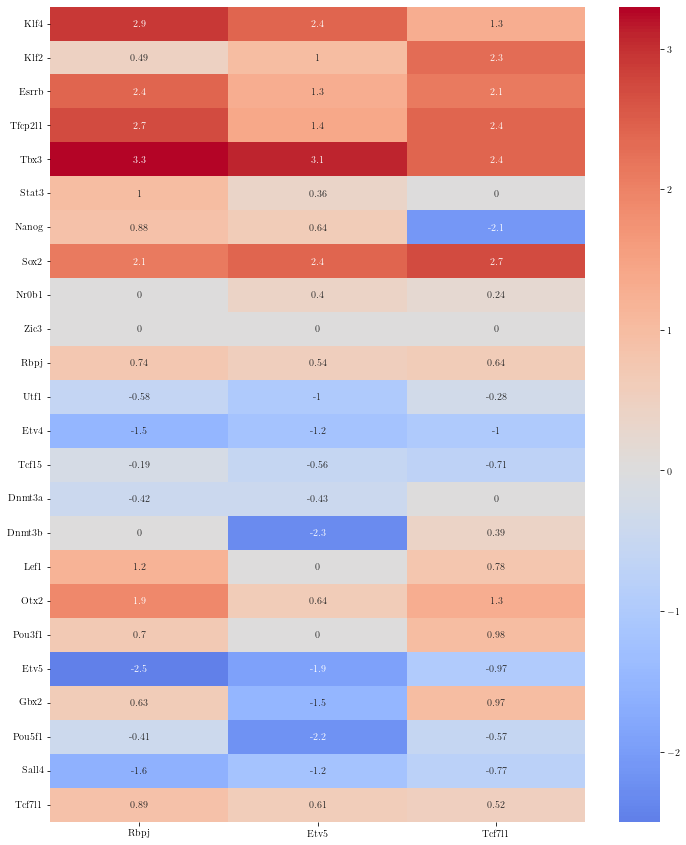

In [67]:
def InteractionList(path="LogFC_Leeb.csv", perc=0.1):
    df = pd.read_csv(path, sep=";")
    df.iloc[:,1:] = df.iloc[:,1:].replace(',', '.', regex=True).astype(float)
    df.set_index(df.columns[0], inplace=True)
    thr = np.abs(df.max().max()*perc)
    output = []
    for row in df.index:
        for col in df.columns:
            element = df.loc[row, col]
            if element > thr:
                sign = "1"
            elif element < -thr:
                sign = "-1"
            else:
                df.loc[row, col] = 0
                sign = "0"
#             if (sign == "-1") or (sign == "1"):
            output.append(f"{col} {row} {sign}")
    return(output, df)

Interactions_list, df = InteractionList(path="LogFC_Leeb.csv", perc=0.05)
df = df.set_index(genes_order)

plt.figure(figsize=(12,15))
sns.heatmap(np.array(df).astype(float), annot=True, fmt="g", 
            xticklabels=df.columns, yticklabels=df.index, 
           cmap="coolwarm", cbar=True, center=0)
plt.show()

# print(1-len(Interactions_list)/( df.shape[0]*df.shape[1]))

# SCODE

In [68]:
# data_PST = pd.read_csv("~/Downloads/SCODE-master/MyData/timePST.txt", sep="\t", header=None)

# data_LN = pd.read_csv("~/Downloads/SCODE-master/MyData/data_LN.txt", sep="\t", header=None)

# data_PST.shape
# data_LN.shape

In [69]:
df_lN = pd.read_csv(path + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.head(3)



,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
1.1,,,,,,,,,,,,,,,,,,,,,
Klf4,1.624017,1.427111,0.000000,0.843545,2.582635,1.825359,0.000000,1.162685,1.708780,0.000000,...,0.0,1.628406,1.075557,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.624017,0.000000,1.436316,1.372344,0.000000,1.430803,2.483172,2.237629,1.093845,1.716736,...,0.0,2.048784,1.075557,0.0,0.0,0.0,2.317913,0.000000,0.0,1.692006
Esrrb,0.000000,1.427111,0.000000,1.372344,1.413292,0.000000,0.000000,1.162685,0.000000,0.000000,...,0.0,1.032705,0.000000,0.0,0.0,0.0,1.219525,0.960339,0.0,0.000000


## PST

,barcodes,time,pst
3696,CGGGACTTCGGCTCTT,00h,0.0
89,AAAGTGACAGGTGGAT,00h,0.0
4382,CTGTACCTCCGCACTT,00h,0.0


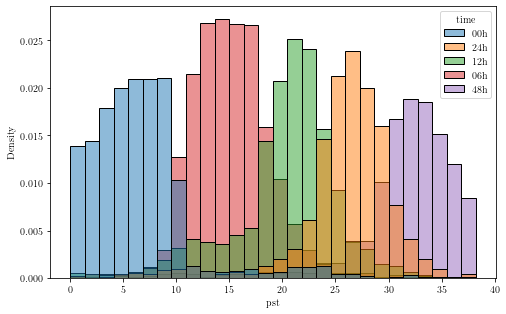

In [70]:
pst_df = pd.read_csv(path+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])



#riordino
pst_df = pst_df.sort_values(by=['pst'])

#plot different times
plt.figure(figsize=(8,5))
sns.histplot(data=pst_df, x="pst", hue="time", stat="density")

column_names = pst_df["barcodes"]

pst_df.head(3)

In [71]:
mb_wind=150
# riordino dataframe 
df_lN_pst = df_lN.reindex(columns = column_names)

df_lN_mb_pst = df_lN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1)
df_lN_mb_pst = pd.DataFrame(df_lN_mb_pst, index=df_lN_pst.index)

df_lN_mb_pst.head(3)



barcodes,GGCGTCAGTCAACGCC,CTCATGCGTCAGGTAG,CTGCCATAGACCGCCT,AGCCAATCAAATCAGA,CGGGTCATCTGGAGAG,TCATTTGTCATCGGGC,AGCATCAAGTACTGGG,ATTCAGGTCGGTTAGT,TCGATTTTCAATCCGA,TATCCTACATAGGTTC,...,TTTGACTTCGCCACTT,GCCATTCTCATTCACT,GAAACCTGTTGTGCCG,CAACCAAAGCCTCACG,TCCTCTTTCGTCCATC,CTAACCCCACAATGCT,CCACACTCACACCAGC,CACGTTCAGCCGAACA,TGATTCTTCCGTTTCG,CTTGATTCACCATTCC
1.1,,,,,,,,,,,,,,,,,,,,,
Klf4,1.237182,1.233101,1.243267,1.243267,1.258404,1.267722,1.283406,1.280832,1.280832,1.278514,...,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.228717,0.228717
Klf2,1.143295,1.152089,1.142363,1.142363,1.148623,1.156669,1.146918,1.144345,1.160804,1.173730,...,0.603555,0.594118,0.579160,0.579160,0.567149,0.567149,0.561093,0.561093,0.547104,0.538954
Esrrb,0.279826,0.288620,0.294988,0.287320,0.273908,0.284033,0.296715,0.296715,0.296715,0.296715,...,0.227777,0.227777,0.227777,0.227777,0.227777,0.235784,0.235784,0.244157,0.250020,0.250020


### Initial vector for SIMULATION

In [72]:
df_lN_mb_pst.iloc[:,:1000].mean(axis=1)


# Creating a column of integers from 0 to the length of the series
df_saving_index = pd.DataFrame(range(len(genes_order))).set_index(genes_order)

# concatenating the series and the index
result = pd.concat([df_saving_index, df_lN_mb_pst.iloc[:,:1000].mean(axis=1)], axis=1)
result
# Saving the resulting DataFrame as a tab-separated text file named 'result.txt'
result.to_csv("initial_GE_LogNorm_MB.txt", sep='\t', index=False, header=False)


In [73]:
data_LN = df_lN_mb_pst.copy()
data_LN.columns = np.arange(0,len(data_LN.columns))
data_LN.index = np.arange(0,len(data_LN.index))

data_LN.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9537,9538,9539,9540,9541,9542,9543,9544,9545,9546
0,1.237182,1.233101,1.243267,1.243267,1.258404,1.267722,1.283406,1.280832,1.280832,1.278514,...,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.228717,0.228717
1,1.143295,1.152089,1.142363,1.142363,1.148623,1.156669,1.146918,1.144345,1.160804,1.173730,...,0.603555,0.594118,0.579160,0.579160,0.567149,0.567149,0.561093,0.561093,0.547104,0.538954
2,0.279826,0.288620,0.294988,0.287320,0.273908,0.284033,0.296715,0.296715,0.296715,0.296715,...,0.227777,0.227777,0.227777,0.227777,0.227777,0.235784,0.235784,0.244157,0.250020,0.250020


In [74]:
data_PST= pst_df.replace("00h", int(0)).replace("06h", int(6)).replace("12h", int(12)).replace("24h", int(24)).replace("48h", int(48))
data_PST = data_PST.iloc[:,1:] #remove Barcodes

#normalize pst between 0 and 1
data_PST["pst"]=data_PST["pst"]/(data_PST["pst"].max())

# rolling average
data_PST = data_PST.rolling(window=mb_wind, axis=0).mean().dropna(axis=0)
data_PST["time"] = data_PST["time"].astype('int')

# rename indices
data_PST.index = np.arange(0,len(data_PST.index))
print(data_PST.shape)
data_PST.tail(5)


(9547, 2)


,time,pst
9542,46,0.977177
9543,46,0.977482
9544,46,0.977785
9545,46,0.978089
9546,46,0.978392


## Check on RSS (100 trials)

In [75]:
# Train and Test
training_data = data_LN.sample(frac=0.8, random_state=2407, replace=False, axis=1)
testing_data  = data_LN.drop(training_data.columns, axis=1)

training_time = data_PST.loc[training_data.columns, :]
testing_time  = data_PST.drop(training_data.columns, axis=0)

# print(training_data.shape[1]+testing_data.shape[1])
print(training_data.shape, testing_data.shape)
print(training_time.shape, testing_time.shape)


(24, 7638) (24, 1909)
(7638, 2) (1909, 2)


In [76]:
# print(training_data.isnull().sum().sum())
# print(testing_data.isnull().sum().sum())
# print(training_time.isnull().sum().sum())
# print(testing_time.isnull().sum().sum())

In [77]:
to_save=False
if to_save==True:
    training_data.to_csv(r'IN_SCODE/PST_MB/train_data.txt', header=None, index=None, sep='\t', mode='w')
    training_time.to_csv(r'IN_SCODE/PST_MB/train_time.txt', header=None, index=None, sep='\t', mode='w')

    testing_data.to_csv(r'IN_SCODE/PST_MB/test_data.txt', header=None, index=None, sep='\t', mode='w')
    testing_time.to_csv(r'IN_SCODE/PST_MB/test_time.txt', header=None, index=None, sep='\t', mode='w')

# Matrices computation

In [78]:
# # path1 =  path+"1_NetworkInference/"

# # Train part with more executions
# genes = 24
# D = [2,3,4,6,8]
# cells_train = 7638
# cells_test = 1909
# iters = 100
# data_GE  = training_data
# data_PST = training_time
# Nexp=100

# for jj in range(len(D)):
#     print("D: ", D[jj])
#     for ii in range(Nexp):
#         print("Exp ", ii)
#         out="OUT_SCODE/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
# #         if not os.path.isdir(out):
# #             os.makedirs(out)
#         out_file = "OUT_SCODE/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
#         # Train
#         ! Rscript ~/Downloads/SCODE-master/SCODE.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/train_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/train_time.txt {out} {genes} {D[jj]} {cells_train} {iters}
#         # Test
#         ! Rscript ~/Downloads/SCODE-master/RSS.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/test_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/test_time.txt {out} {out_file} {genes} {D[jj]} {cells_test}
        


# From Here to not recompute ALL

In [79]:
# Compute D quantile
genes = 24
D = [2,3,4,6,8]
cells_train = 7638
cells_test = 1909
iters = 100
data_GE  = training_data
data_PST = training_time
Nexp=100

RSS_vect = np.zeros((len(D), Nexp))
RSS_quantile = np.zeros((3,len(D)))

# TP_vect = np.zeros((len(D),Nexp))
# TP_max = np.zeros(len(D))
# A_tot = np.zeros((genes, genes, len(D)))
# A_mean = np.zeros((genes, genes, len(D)))
A_sample = np.zeros((genes, genes, len(D), Nexp))
for jj in range(len(D)):
    print("D: ", D[jj])
    for ii in range(Nexp):
        out=       "OUT_SCODE copia/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
        out_file = "OUT_SCODE copia/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
        RSS_vect[jj,ii] = np.array(pd.read_csv(out_file, sep="\t", header=None))
#         print(D[jj], ii, RSS_vect[jj,ii])
        A_sample[:,:,jj,ii] = pd.read_csv(out+"/A.txt", sep="\t", header=None)
#         A_tot[:,:,jj] += locals()["A"+str(ii)]
#     A_mean = A_tot[:,:,jj]/Nexp
        
    RSS_quantile[:,jj] = np.array([np.quantile(RSS_vect[jj,:], 0.25), np.quantile(RSS_vect[jj,:], 0.5), np.quantile(RSS_vect[jj,:], 0.75)])
#     TP_max[jj] = TP_vect[jj,:].max()



D:  2
D:  3
D:  4
D:  6
D:  8


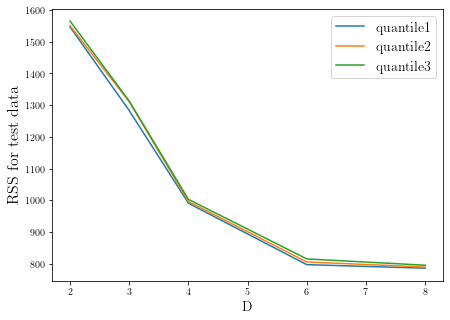

In [80]:
plt.figure(figsize=(7,5))
for ii in range(RSS_quantile.shape[0]):
    plt.plot(D, RSS_quantile[ii,:], label="quantile"+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("RSS for test data", fontsize=16)
    plt.xlabel("D", fontsize=14)    

In [81]:
# Per OGNI D: Devo riordinare in ordine crescente di RSS e poi prendere i 50 RSS più piccoli
A_sel = np.zeros((genes, genes, len(D), 50))
A_lin = np.zeros((genes*genes, len(D), 50))

for jj in range(len(D)):
    idx = np.argsort(RSS_vect[jj,:])[:50]  
    for ii in range(len(idx)):
        A_sel[:,:,jj,ii] = A_sample[:,:,jj,idx[ii]]
        A_lin[:,jj,ii] = A_sample[:,:,jj,idx[ii]].flatten()
        
    


In [82]:
A_lin.shape

(576, 5, 50)

In [83]:

A_quantile = np.zeros((3,len(D)))
for jj in range(len(D)):
    A_exp_corr = np.corrcoef(A_lin[:,jj,:].T)
#     print(np.quantile(A_exp_corr, 0.25))
    A_quantile[:,jj] = np.array([np.quantile(A_exp_corr, 0.25), np.quantile(A_exp_corr, 0.5), np.quantile(A_exp_corr, 0.75)])


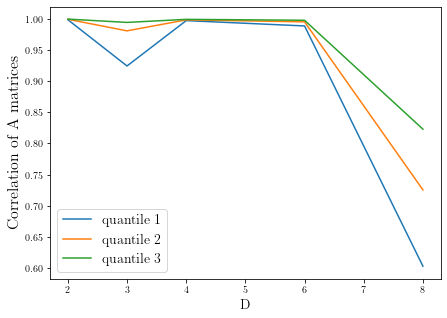

In [84]:
plt.figure(figsize=(7,5))
for ii in range(A_quantile.shape[0]):
    plt.plot(D, A_quantile[ii,:], label="quantile "+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("Correlation of A matrices", fontsize=16)
    plt.xlabel("D", fontsize=14) 

# Interaction Matrix for D=6

## Thr=0.01

thr= 0.01
D= 6


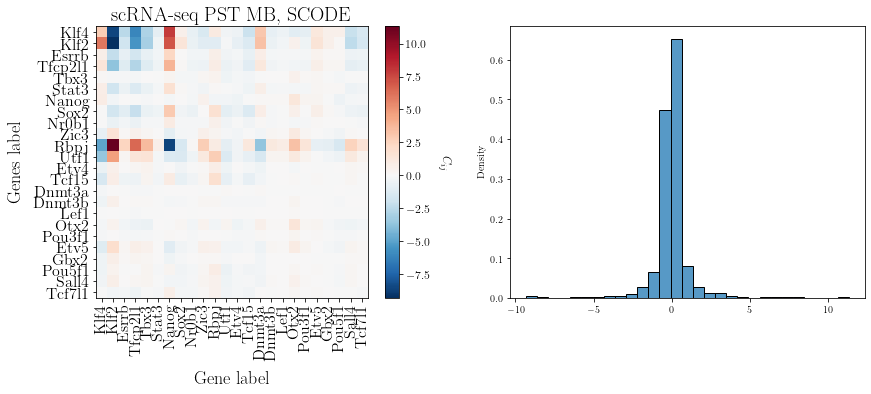

TP fraction  0.3333333333333333
Not Normalized TRUE interactions [-0.    2.38 -0.   -0.    0.    0.   -0.    0.3  -0.   -0.42 -1.53 -0.
 -0.   -0.66 -0.28  0.    0.    0.  ]
Normalized TRUE interactions [-0.    0.21 -0.   -0.    0.    0.   -0.    0.03 -0.   -0.04 -0.14 -0.
 -0.   -0.06 -0.03  0.    0.    0.  ]
Not Normalized interactions [-0.83  2.38 -0.01 -0.03  0.14  0.01 -0.41  0.3  -0.06 -0.42 -1.53 -0.1
 -0.11 -0.66 -0.28  0.41  0.04  0.09]
Normalized interactions [-0.07  0.21 -0.   -0.    0.01  0.   -0.04  0.03 -0.01 -0.04 -0.14 -0.01
 -0.01 -0.06 -0.03  0.04  0.    0.01]


2nd set of interactions, TPfrac:
0.35


In [85]:
sel_thr = 0.01
print("thr=", sel_thr)

DD = 3
print("D=", D[DD])
A_tot = np.sum(A_sel[:,:,DD,:100], axis=2 )/100

TP_fraction, TP_info, interaction_matrix = TP_plot(TPtrial_list, A_tot, genes_order, inferred_int_thr=sel_thr, 
                                                   Norm_Matx = False, data_type="scRNA-seq PST MB, SCODE",
                                                   figplot=True, nbin=30, 
                                                    verbose=False, Norm=True)
                                        
                                                   
                                                    
print("TP fraction ", TP_fraction)

print("Not Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:],2))
print("Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:]/np.max(np.abs(A_tot)), 2))

print("Not Normalized interactions", np.round(TP_info[2,:],2))
print("Normalized interactions", np.round(TP_info[2,:]/np.max(np.abs(A_tot)), 2))


TP_fraction2, TP_info2, _ = TP_plot(Interactions_list, A_tot, genes_order, 
                                   inferred_int_thr = sel_thr, Norm_Matx = False,
                                   data_type=" Best model for BULK data",
                                   figplot=False, verbose=False, nbin=30, Norm = True)
print("\n\n2nd set of interactions, TPfrac:")
print(f"{TP_fraction2:.2f}")




### Fraction of discarded

In [86]:
high_meanMatx_thr = na.to_thr_matrix(A_tot, thr=sel_thr)
print(1-(len(np.where(high_meanMatx_thr==0)[0]))/(24**2))
print(len(np.where(A_tot==0)[0]))

0.6579861111111112
0


# Network Analysis

## Interactions and Adjacency Matrix

In [87]:
thr = 0.05

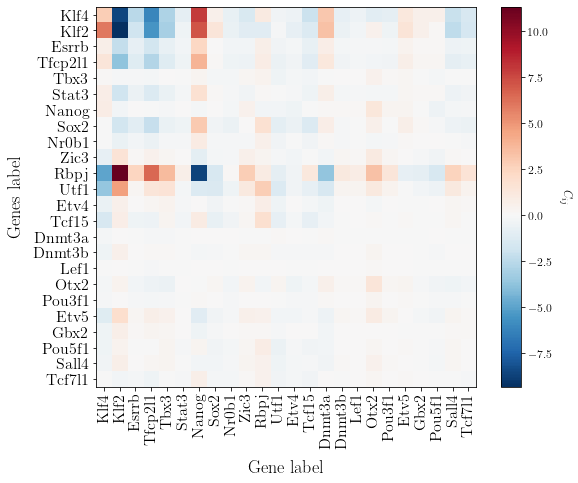

In [88]:
na.intM_plot(A_tot)

Min and Max values of J:  11.3113 -9.3322
0.5655674892924334


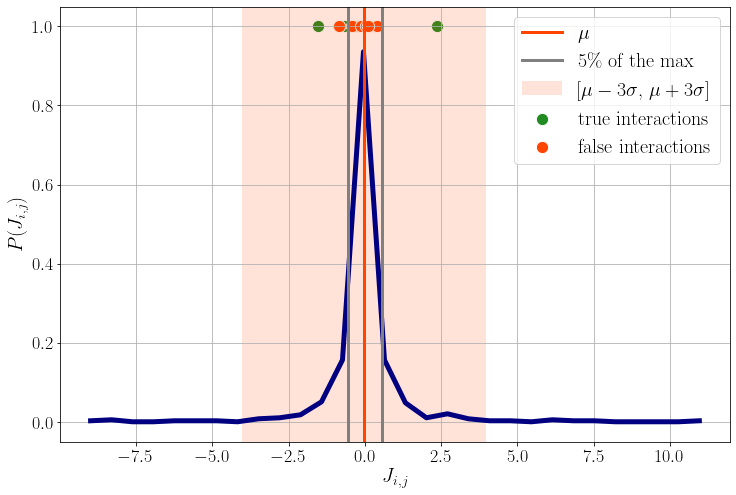

In [89]:
print("Min and Max values of J: ", np.round(A_tot.max(),4), np.round(A_tot.min(),4))

na.interactions_plot(A_tot, TP_info)

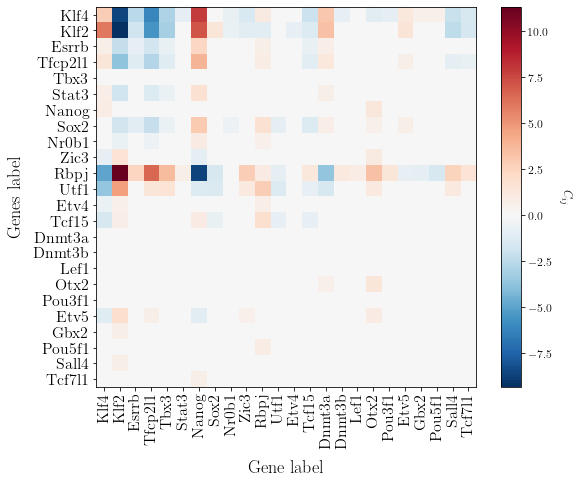

In [90]:
A_tot_thr = na.to_thr_matrix(A_tot, thr=thr)
na.intM_plot(A_tot_thr)

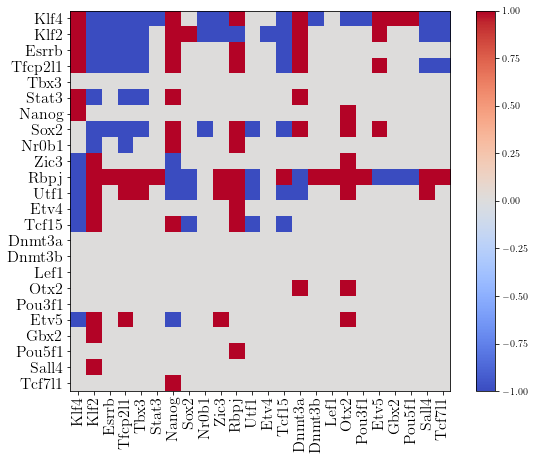

%1s : 0.12
%-1s : 0.12
%0s : 0.75


In [91]:
adj_matx = na.to_adj_matrix(A_tot, thr = thr)
na.adj_plot(adj_matx)

print("%1s :", f"{len(np.where(adj_matx==1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")
print("%-1s :", f"{len(np.where(adj_matx==-1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

print("%0s :", f"{len(np.where(adj_matx==0)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

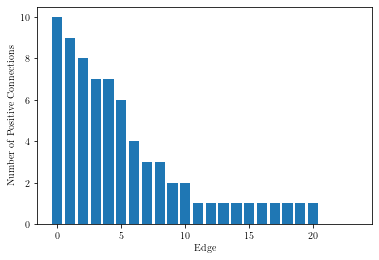

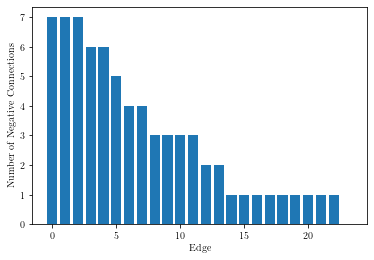

In [92]:
# calculate the number of positive connections for each edge
positive_connections = np.sum(np.clip(adj_matx, 0, None), axis=0)

# calculate the number of negative connections for each edge
negative_connections = np.sum(np.clip(adj_matx, None, 0), axis=0)

# sort the connections in descending order
positive_connections_sorted = np.sort(positive_connections)[::-1]
negative_connections_sorted = np.abs(np.sort(negative_connections))

# plot the positive connections
plt.bar(np.arange(len(positive_connections_sorted)), positive_connections_sorted)
plt.xlabel("Edge")
plt.ylabel("Number of Positive Connections")
plt.show()

# plot the negative connections
plt.bar(np.arange(len(negative_connections_sorted)), negative_connections_sorted)
plt.xlabel("Edge")
plt.ylabel("Number of Negative Connections")
plt.show()


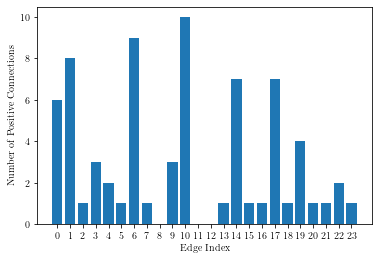

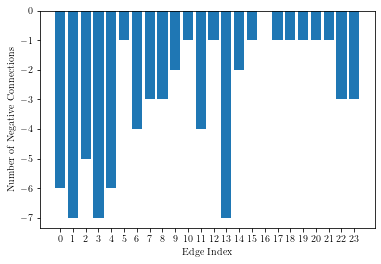

In [93]:
# calculate the number of positive connections for each edge
positive_connections = np.sum(np.clip(adj_matx, 0, None), axis=0)

# calculate the number of negative connections for each edge
negative_connections = np.sum(np.clip(adj_matx, None, 0), axis=0)

# sort the indices in descending order of the positive connections
positive_indices_sorted = np.argsort(positive_connections)[::-1]

# sort the indices in descending order of the negative connections
negative_indices_sorted = np.argsort(negative_connections)[::-1]

# plot the positive connections
plt.bar(positive_indices_sorted, np.sort(positive_connections)[::-1])
plt.xlabel("Edge Index")
plt.ylabel("Number of Positive Connections")
plt.xticks(positive_indices_sorted)
plt.show()

# plot the negative connections
plt.bar(negative_indices_sorted, np.sort(negative_connections)[::-1])
plt.xlabel("Edge Index")
plt.ylabel("Number of Negative Connections")
plt.xticks(negative_indices_sorted)
plt.show()


In [94]:
np.sum(positive_connections_sorted[:5])/np.sum(positive_connections_sorted)

0.5774647887323944

In [95]:
np.sum(negative_connections_sorted[:5])/np.sum(negative_connections_sorted)

0.4647887323943662

## Reciprocity

In [96]:
reciprocity_value = na.reciprocity(adj_matx)
print(reciprocity_value)

0.31


In [97]:
# nodes_rec, mean_TypeGenes, std_TypeGenes = na.nodes_reciprocity(adj_matx, net_reciprocity = reciprocity_value, genes_list=genes_order)

# print("Naive", "{:.2f}".format(mean_TypeGenes[0]), "+\_", "{:.2f}".format(std_TypeGenes[0]))
# print("Formative", "{:.2f}".format(mean_TypeGenes[1]), "+\_", "{:.2f}".format(std_TypeGenes[1]))
# print("Committed", "{:.2f}".format(mean_TypeGenes[2]), "+\_", "{:.2f}".format(std_TypeGenes[2]))
# print("Others", "{:.2f}".format(mean_TypeGenes[3]), "+\_", "{:.2f}".format( std_TypeGenes[3]))





## Degree

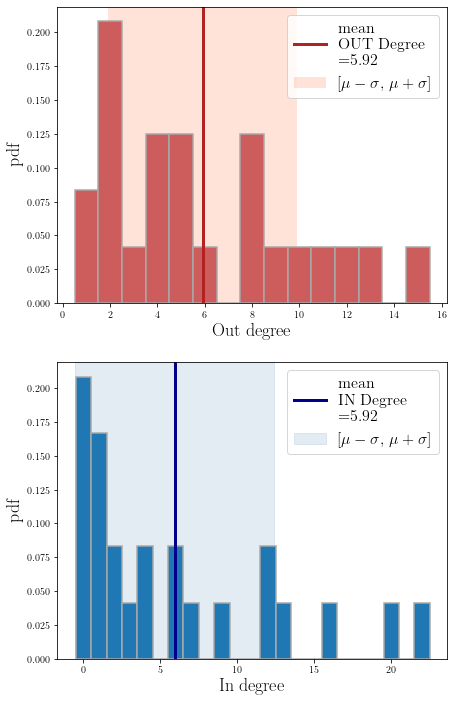

In [98]:
na.plot_degree_distribution(adj_matx)


22.0 15.0


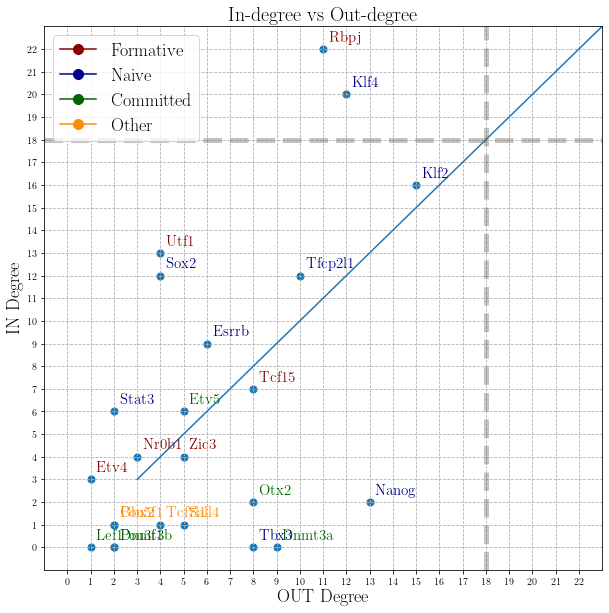

0.47


In [99]:
outdegree, indegree, Sp_corr = na.plot_indegree_outdegree(adj_matx)
print(f"{Sp_corr:.2f}")

## INTERACTION DISTRIBUTION

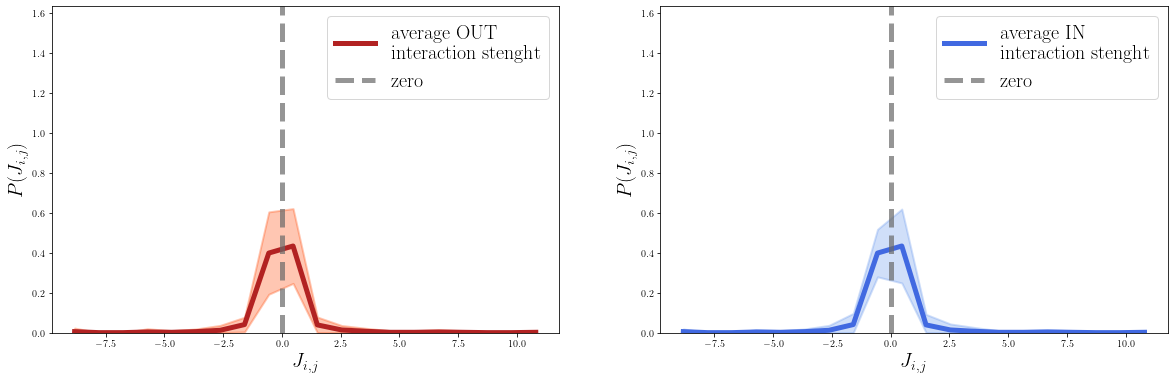

In [100]:
na.plot_histograms(A_tot)


### Hubs

OUT hubs:
 ['Klf2' 'Nanog' 'Klf4' 'Rbpj' 'Tfcp2l1']
IN hubs:
 ['Rbpj' 'Klf4' 'Klf2' 'Utf1' 'Tfcp2l1']
OUT hubs


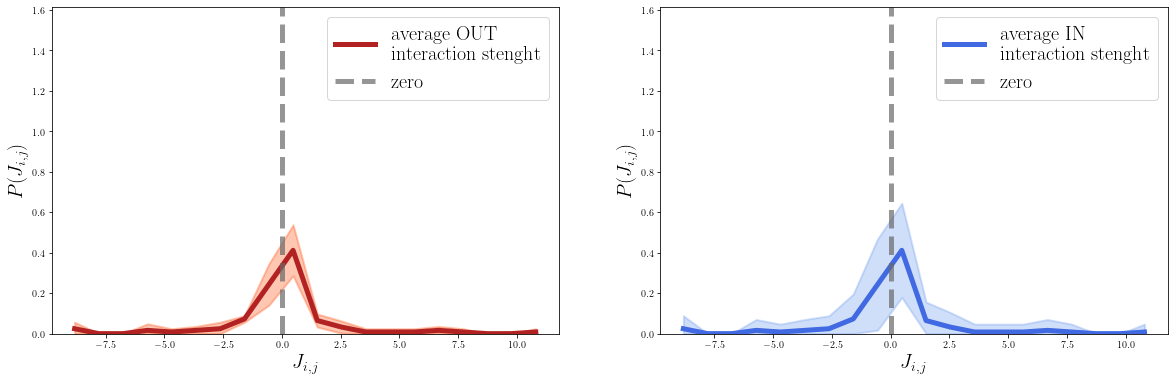

IN hubs


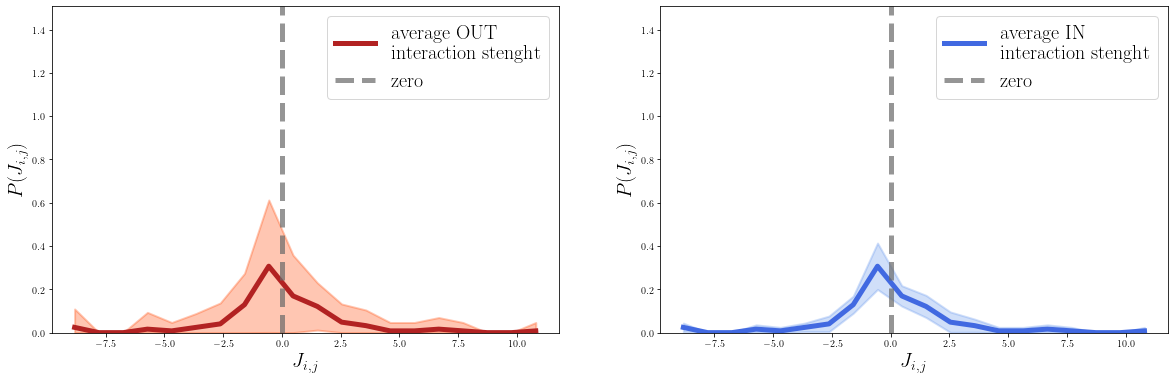

In [101]:
n_hubs = 5
print("OUT hubs:\n", na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])
print("IN hubs:\n", na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])

print("OUT hubs")
out_hubs_idxs = na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(A_tot[:,out_hubs_idxs.astype("int")])

print("IN hubs")
in_hubs_idxs = na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(A_tot[in_hubs_idxs.astype("int"), :])


## Network

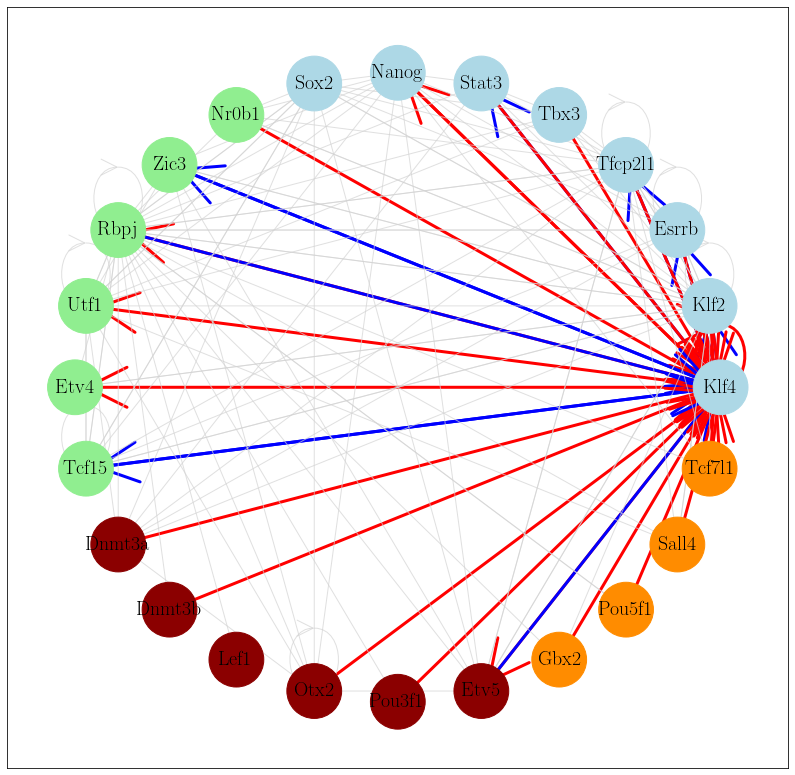

In [102]:
na.visualize_graph_selNode(adj_matx, genes_order, naive, formative, committed, "Klf4")


In [103]:
interactions = na.string_list_to_tuple(TPtrial_list)
correlations_known = na.string_list_to_tuple(Interactions_list)

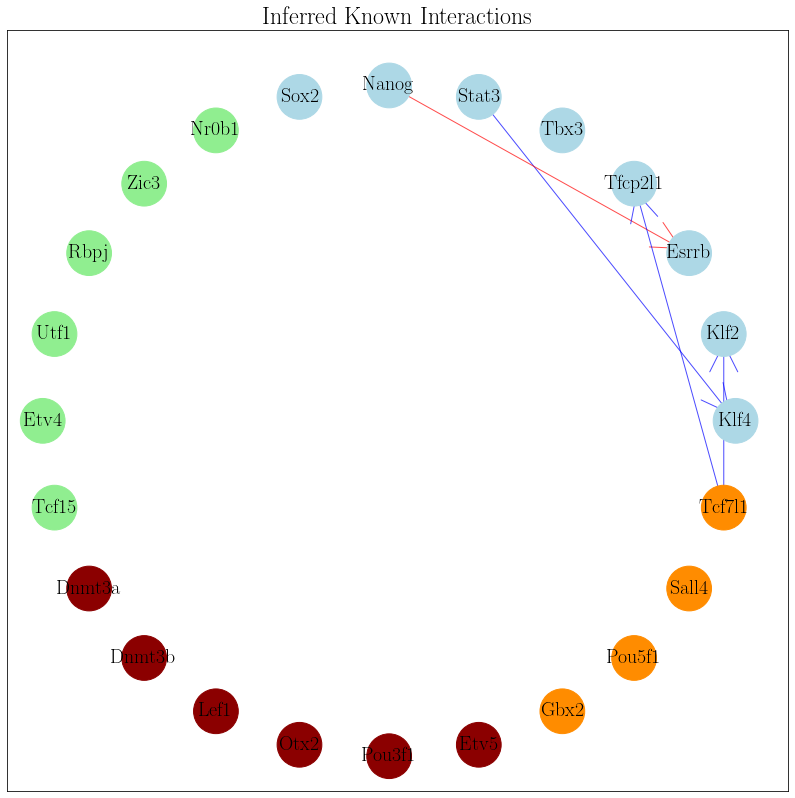

In [104]:
na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  interactions, "Inferred Known Interactions")


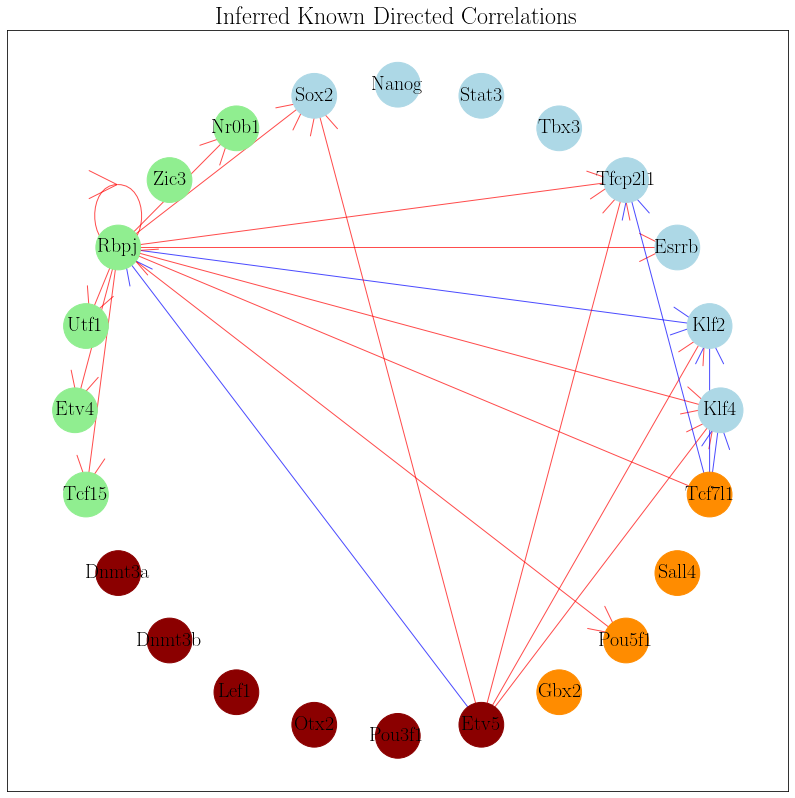

In [105]:
na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  correlations_known, "Inferred Known Directed Correlations")


# Simulated

In [106]:
np.savetxt("A_sel_LogNorm_MB.txt",A_tot)

In [107]:
def binnarization(df, thr=0.5, genes_order=[]):
    # Calculate the maximum value for each row of the DataFrame
    df_max = df.max(axis=1)

    # Create a copy of the DataFrame to store the binarized values
    spins_df = df.copy()

    # Loop through each row of the DataFrame: genes_order contains the genes of the dataframe
    for ii in range(len(genes_order)):
        # Binarize the values in the row
        spins_df.iloc[ii,:] = (df.iloc[ii,:].astype(float) > (df_max[ii] * thr)).astype(float)
#     print(ii, np.unique(spins_df), pd.DataFrame.isna(spins_df).sum().sum())
        
#     Replace all 0 values with -1
#     spins_df[spins_df==float(0)] = float(-1.0)
    spins_df = spins_df.apply(lambda x: np.where(x == 0, -1, x))
    # Return the binarized DataFrame
    return spins_df

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [108]:
df_sim = pd.read_table("out_simSCODE_LogNorm_MB.txt", delimiter="\t", dtype={"Value": float}).set_index(genes_order)
df_sim.shape

(24, 501)

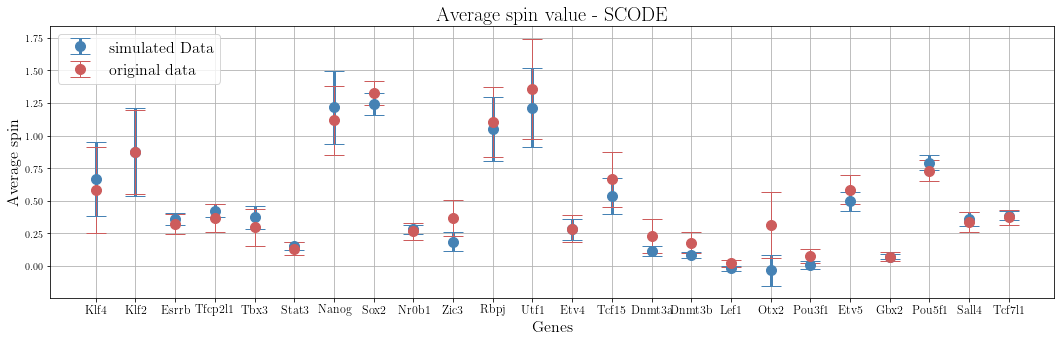

In [119]:
plt.figure(figsize=(18,5))
plt.errorbar(genes_order, df_sim.mean(axis=1), yerr=df_sim.std(axis=1)/np.sqrt(24),  
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=3,
             color="steelblue",
             capsize=10,
             label= "simulated Data")

plt.errorbar(genes_order, data_LN.mean(axis=1), yerr=data_LN.std(axis=1)/np.sqrt(24), 
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=1,
             color="indianred",
             capsize=10,
             label = "original data")
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel("Average spin", fontsize=16)
plt.xlabel("Genes", fontsize=16)
plt.title("Average spin value - SCODE", fontsize=20)
plt.grid(True)

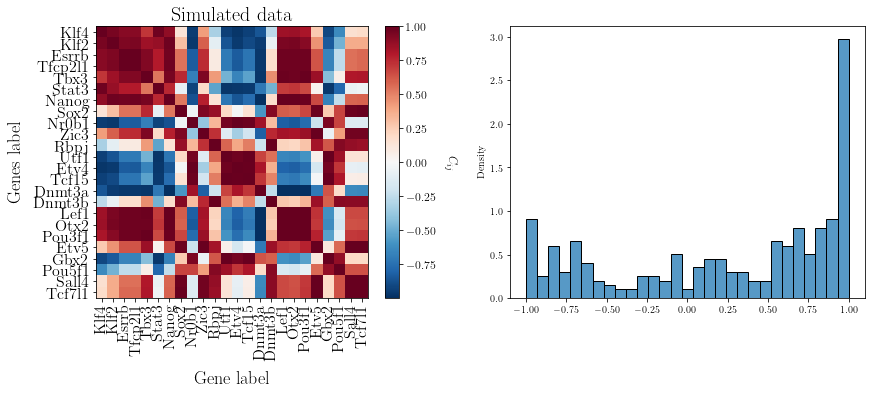

In [109]:
cm_sim_SCODE_PST_MB_lN_Cont = np.corrcoef(df_sim)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_SCODE_PST_MB_lN_Cont, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim_SCODE_PST_MB_lN_Cont), bins=bins,  ax=ax[1], stat="density")
plt.show()

# # plt.imshow(np.corrcoef(spins_new_lN))
# print(np.where(spins_sim==float("nan")))



## Original CM

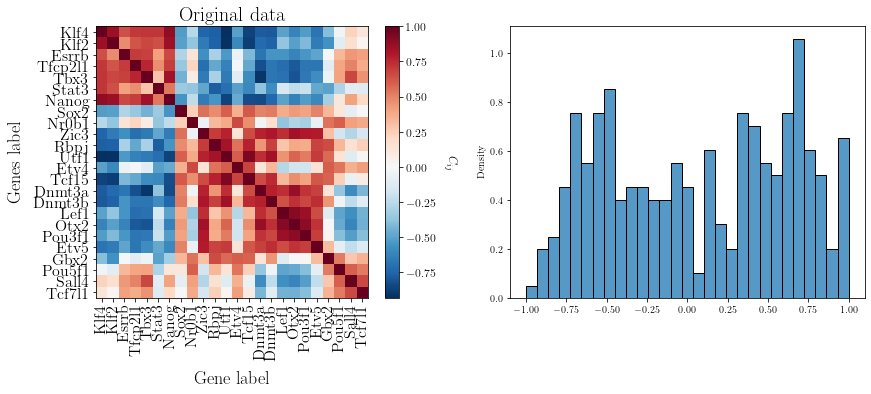

In [110]:
cm_pst_mb_psiNorm = np.corrcoef(data_LN)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_pst_mb_psiNorm, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_pst_mb_psiNorm), bins=bins,  ax=ax[1], stat="density")
plt.show()

In [111]:
def sum_squared_abs_diff(array1, array2):
    diff = (array1.flatten()-array2.flatten())**2
    return np.sqrt(np.sum(diff))

In [112]:
N_rows = data_LN.shape[0]
N_cols = data_LN.shape[1]
Ntest=100
# Linearize
val_rnd = np.reshape(np.array(data_LN), (N_cols*N_rows))

# reshuflle for Ntest times
df_pN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) ########################
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    df_pN_mb_pst_shuffle[ii,:,:] = trial_long


corr_matxs_rnd = np.array([np.corrcoef(df_pN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])


In [113]:
noise_dist = [sum_squared_abs_diff(cm_pst_mb_psiNorm, corr_matxs_rnd[i,:,:]) for i in range(Ntest)]

noise_dist = np.mean(noise_dist)

result_SO = sum_squared_abs_diff(cm_pst_mb_psiNorm, cm_sim_SCODE_PST_MB_lN_Cont)/noise_dist
print(f"Scode - Orig {result_SO:.2f}")


Scode - Orig 1.36


In [114]:
np.savetxt('cm_sim_SCODE_MB_LogNorm.txt', cm_sim_SCODE_PST_MB_lN_Cont)

In [ ]:
df_max = np.array(df_sim.max(axis=1))
thr = 0.5

for ii in range(len(genes_order)):
    plt.plot(np.linspace(0, len(df_sim.iloc[ii,:]), len(df_sim.iloc[ii,:])), df_sim.iloc[ii,:])
    plt.axhline(y = df_max[ii]*thr, linestyle = 'dotted', color = "darkorange")
    plt.title(genes_order[ii])
    plt.ylim(0, df_max[ii]+0.1*df_max[ii])
    plt.show()


In [ ]:
thr = 0.5 

spins_df_sim = binnarization(df_sim, thr=thr, genes_order=genes_order)
spins_sim = np.array(spins_df_sim).astype(float)


In [ ]:
plt.figure(figsize=(7,5))

fun_plotting.raster_plot(spins_sim, ax_names=genes_order)
plt.show()

In [ ]:
# df_lN_mb_pst = df_lN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1)
# df_lN_mb_pst = pd.DataFrame(df_lN_mb_pst, index=df_lN_pst.index)
spins_df_lN_mb_pst = binnarization(df_lN_mb_pst, thr=thr, genes_order=genes_order)
# spins_df_lN_pst = binnarization(df_lN_pst, thr=thr, genes_order=genes_order)


plt.figure(figsize=(18,5))
plt.errorbar(genes_order, spins_sim.mean(axis=1), yerr=spins_sim.std(axis=1)/np.sqrt(24),  
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=3,
             color="steelblue",
             capsize=10,
             label= "simulated Data")
plt.errorbar(genes_order, spins_df_lN_mb_pst.mean(axis=1), yerr=spins_df_lN_mb_pst.std(axis=1)/np.sqrt(24), 
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=1,
             color="indianred",
             capsize=10,
             label = "original data with MB")


plt.legend(loc="upper left", fontsize=16,bbox_to_anchor=(1.01, 1))
plt.xticks(fontsize=12)
plt.ylabel("Average spin", fontsize=16)
plt.xlabel("Genes", fontsize=16)
plt.title("Average spin values for each genes", fontsize=20)
plt.grid(True)

np.save("avg_spins_lN", spins_sim)

In [ ]:
cm_sim_SCODE_PST_MB_LogNorm = np.corrcoef(spins_sim)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_SCODE_PST_MB_LogNorm, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim_SCODE_PST_MB_LogNorm), bins=bins,  ax=ax[1], stat="density")
plt.show()

# plt.imshow(np.corrcoef(spins_new_lN))
print(np.where(spins_sim==np.float("nan")))

np.savetxt('cm_sim_SCODE_PST_MB_LogNorm.txt', cm_sim_SCODE_PST_MB_LogNorm)

# KO

## Rpbj

### For R computation

In [59]:
KO_gene = "Rbpj"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv("initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt("A_KO_LogNorm_MB.txt",KO_lN_rec_matx)


### generate KO data

In [60]:

KO_df_sim = pd.read_table("out_simSCODE_LogNorm_MB_KO.txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
KO_avg_GE = KO_df_sim.mean(axis=1)


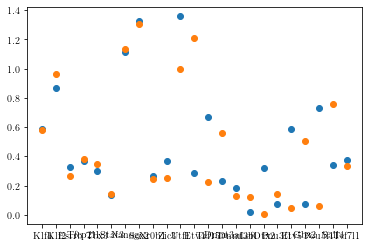

In [61]:
wt_avg_GE = np.delete(np.array(data_LN.mean(axis=1)), KO_gene_idk)
plt.plot(wt_avg_GE, 'o')
plt.plot(KO_avg_GE, 'o')


In [62]:
## From Martin Leeb work
# Dataframe with all the KO data
Interactions_list, df = InteractionList(path="LogFC_Leeb.csv", perc=0.05)
df = df.set_index(genes_order)

# select only the desidered knockout
logFC_True_rbpj = np.delete(np.array(df.iloc[:,0]), KO_gene_idk)

## Computed
logFC_sim_Rbpj =  np.log2((KO_avg_GE)/ (wt_avg_GE))



In [63]:
def count_same_sign_elements(arr1, arr2):
    """
    Count the number of elements that have the same sign in two arrays.
    """
    mask = np.sign(arr1) == np.sign(arr2)
    return np.sum(mask)

### Comparison

In [64]:
# Find the indices where x is non-zero
nonzero_indices = logFC_True_rbpj != 0
print(np.sum(nonzero_indices))
# Filter x and y based on the non-zero indices
logFC_True_rbpj_filtered = logFC_True_rbpj[nonzero_indices]
logFC_sim_Rbpj_filtered = logFC_sim_Rbpj[nonzero_indices]
genes_inter_DC = KO_genes_order[nonzero_indices]

print("same behaviour", count_same_sign_elements(logFC_True_rbpj_filtered, logFC_sim_Rbpj_filtered)/len(logFC_sim_Rbpj_filtered))


20
same behaviour 0.6


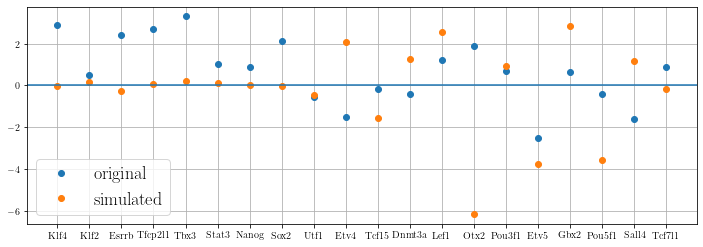

In [65]:
plt.figure(figsize=(12,4))
plt.plot(genes_inter_DC, logFC_True_rbpj_filtered, "o", label="original")
plt.plot(genes_inter_DC, logFC_sim_Rbpj_filtered, "o", label="simulated")
plt.legend(fontsize=18)
plt.axhline(0)
plt.grid()
plt.show()

0.23613042107609883
0.10583585790522053


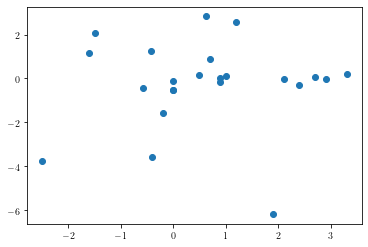

In [66]:
from scipy.stats import spearmanr

plt.scatter(logFC_True_rbpj, logFC_sim_Rbpj)
print(spearmanr(np.sign(logFC_True_rbpj), np.sign(logFC_sim_Rbpj))[0])
print(spearmanr(logFC_True_rbpj, logFC_sim_Rbpj)[0])

## Etv5

### For R computation

In [67]:
KO_gene = "Etv5"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv("initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt("A_KO_LogNorm_MB.txt",KO_lN_rec_matx)


### generate KO data

In [68]:

KO_df_sim = pd.read_table("out_simSCODE_LogNorm_MB_KO.txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
KO_avg_GE = KO_df_sim.mean(axis=1)
KO_avg_GE[KO_avg_GE<=0]=0


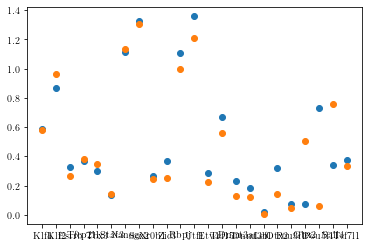

In [69]:
wt_avg_GE = np.delete(np.array(data_LN.mean(axis=1)), KO_gene_idk)
plt.plot(wt_avg_GE, 'o')
plt.plot(KO_avg_GE, 'o')


In [70]:
## From Martin Leeb work
# Dataframe with all the KO data
Interactions_list, df = InteractionList(path="LogFC_Leeb.csv", perc=0.05)
df = df.set_index(genes_order)

# select only the desidered knockout
logFC_True_rbpj = np.delete(np.array(df.iloc[:,1]), KO_gene_idk)

## Computed
logFC_sim_Rbpj =  np.log2((KO_avg_GE)/ (wt_avg_GE))



### Comparison

In [71]:
# Find the indices where x is non-zero
nonzero_indices = logFC_True_rbpj != 0
print(np.sum(nonzero_indices))
# Filter x and y based on the non-zero indices
logFC_True_rbpj_filtered = logFC_True_rbpj[nonzero_indices]
logFC_sim_Rbpj_filtered = logFC_sim_Rbpj[nonzero_indices]
genes_inter_DC = KO_genes_order[nonzero_indices]

print("same behaviour", count_same_sign_elements(logFC_True_rbpj_filtered, logFC_sim_Rbpj_filtered)/len(logFC_sim_Rbpj_filtered))


20
same behaviour 0.55


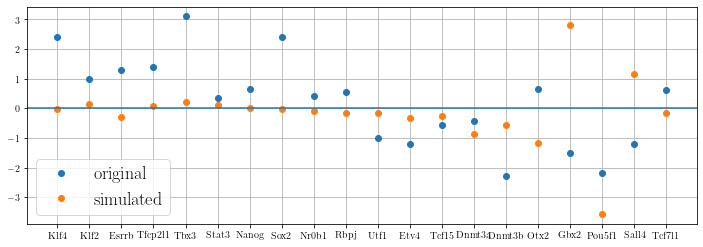

In [72]:
plt.figure(figsize=(12,4))
plt.plot(genes_inter_DC, logFC_True_rbpj_filtered, "o", label="original")
plt.plot(genes_inter_DC, logFC_sim_Rbpj_filtered, "o", label="simulated")
plt.legend(fontsize=18)
plt.axhline(0)
plt.grid()
plt.show()

0.1972140924690684
0.3380356469841367


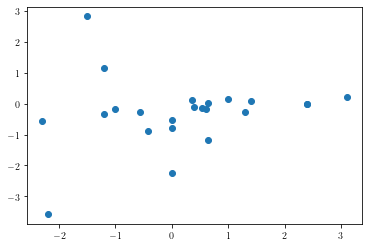

In [73]:
from scipy.stats import spearmanr

plt.scatter(logFC_True_rbpj, logFC_sim_Rbpj)
print(spearmanr(np.sign(logFC_True_rbpj), np.sign(logFC_sim_Rbpj))[0])
print(spearmanr(logFC_True_rbpj, logFC_sim_Rbpj)[0])

## Tcf7l1

### For R computation

In [74]:
KO_gene = "Tcf7l1"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv("initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt("A_KO_LogNorm_MB.txt",KO_lN_rec_matx)


### generate KO data

In [75]:

KO_df_sim = pd.read_table("out_simSCODE_LogNorm_MB_KO.txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
KO_avg_GE = KO_df_sim.mean(axis=1)
KO_avg_GE[KO_avg_GE<=0]=0


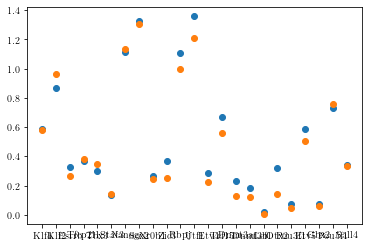

In [76]:
wt_avg_GE = np.delete(np.array(data_LN.mean(axis=1)), KO_gene_idk)
plt.plot(wt_avg_GE, 'o')
plt.plot(KO_avg_GE, 'o')


In [77]:
## From Martin Leeb work
# Dataframe with all the KO data
Interactions_list, df = InteractionList(path="LogFC_Leeb.csv", perc=0.05)
df = df.set_index(genes_order)

# select only the desidered knockout
logFC_True_rbpj = np.delete(np.array(df.iloc[:,2]), KO_gene_idk)

## Computed
logFC_sim_Rbpj =  np.log2((KO_avg_GE)/ (wt_avg_GE))



### Comparison

In [78]:
# Find the indices where x is non-zero
nonzero_indices = logFC_True_rbpj != 0
print(np.sum(nonzero_indices))
# Filter x and y based on the non-zero indices
logFC_True_rbpj_filtered = logFC_True_rbpj[nonzero_indices]
logFC_sim_Rbpj_filtered = logFC_sim_Rbpj[nonzero_indices]
genes_inter_DC = KO_genes_order[nonzero_indices]

print("same behaviour", count_same_sign_elements(logFC_True_rbpj_filtered, logFC_sim_Rbpj_filtered)/len(logFC_sim_Rbpj_filtered))


20
same behaviour 0.4


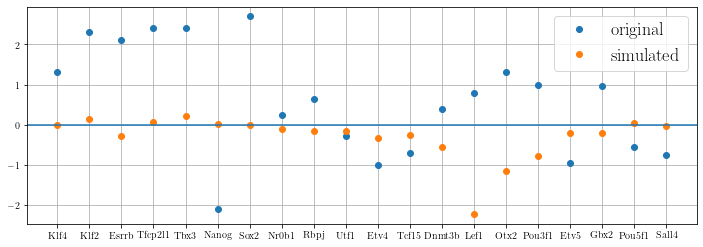

In [79]:
plt.figure(figsize=(12,4))
plt.plot(genes_inter_DC, logFC_True_rbpj_filtered, "o", label="original")
plt.plot(genes_inter_DC, logFC_sim_Rbpj_filtered, "o", label="simulated")
plt.legend(fontsize=18)
plt.axhline(0)
plt.grid()
plt.show()

-0.06715507368448512
0.15239996998371202


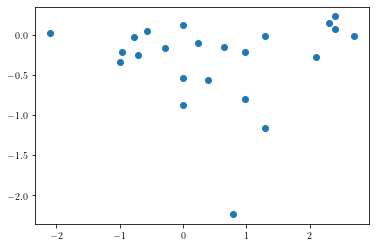

In [80]:
from scipy.stats import spearmanr

plt.scatter(logFC_True_rbpj, logFC_sim_Rbpj)
print(spearmanr(np.sign(logFC_True_rbpj), np.sign(logFC_sim_Rbpj))[0])
print(spearmanr(logFC_True_rbpj, logFC_sim_Rbpj)[0])

In [89]:
# threshold = 0.01
# # Set the bins
# bins = np.linspace(A_tot.min(), A_tot.max(), 10000)

# # Plot the histogram
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))
# sns.histplot(A_tot.flatten(), ax=ax, stat="density", bins=bins)
# plt.axvline(threshold, color='red', linestyle='-')
# plt.axvline(threshold, color='red', linestyle='-')
# plt.xlim([-threshold, threshold])

# # Get the x and y values of the bars
# x = np.array([p.get_x() + p.get_width()/2 for p in ax.patches])
# y = np.array([p.get_height() for p in ax.patches])

# # Compute the widths of the bins
# bin_widths = np.diff(bins)

# # Compute the area under the curve between -0.1 and 0.1
# print("check", np.where((x > -threshold) & (x < threshold)))
# area = np.sum(y[(x > -threshold) & (x < threshold)] * bin_widths[(x > -threshold) & (x < threshold)])

# print("Area not considered", area)


In [90]:
# A_tot.max()*0.005

In [91]:
# DD = 2
# print("D=", D[DD])
# A_tot = np.sum(A_sel[:,:,DD,:100], axis=2 )/100
        
# bins = np.linspace(A_tot.min(), A_tot.max(), 30)
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# figfunc.plotmat(A_tot, fig, ax[0], genes_order, data_type+" SCODE not rescaled")
# sns.histplot(np.ndarray.flatten(A_tot), ax=ax[1], stat="density", bins=bins)
# plt.show()

# TP_fraction, TP_info, interaction_matrix = TP_plot(TPtrial_list, A_tot, genes_order, inferred_int_thr=0.0, 
#                                                    Norm_Matx = False, data_type="scRNA-seq PST MB, SCODE",
#                                                    figplot=False, nbin=30, 
#                                                     verbose=False, Norm=False)
                                        
                                                   
                                                    
# print("TP fraction ", TP_fraction)
# result = TP_info[2,:]*TP_info[3,:]
# non_zero_values = result[np.nonzero(result)]
# print(np.nanmin(np.abs(non_zero_values)))
# print("Not Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:],2))
# print("Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:]/np.max(np.abs(A_tot)), 2))

# print("Not Normalized interactions", np.round(TP_info[2,:],2))
# print("Normalized interactions", np.round(TP_info[2,:]/np.max(np.abs(A_tot)), 2))
